<strong><font size="8">A1</font></strong>

In [1]:
import mne
from mne.preprocessing import ICA, corrmap, create_ecg_epochs #for removing heartbeats
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import os
import pathlib

data_path = mne.datasets.sample.data_path()

print(f"{mne.__version__=}")
print(data_path)

mne.__version__='1.9.0'
C:\Users\snowy\mne_data\MNE-sample-data


<strong><font size="6">1.1</font></strong>

In [2]:
raw_path = os.path.join(data_path, "MEG", "sample", "sample_audvis_raw.fif") #finds sample data in storage

raw = mne.io.read_raw_fif(raw_path, preload=True) #preloads data into memory for processing

# raw.crop(0, 60).load_data() #saves only first 60 seconds to memory

Opening raw data file C:\Users\snowy\mne_data\MNE-sample-data\MEG\sample\sample_audvis_raw.fif...
    Read a total of 3 projection items:
        PCA-v1 (1 x 102)  idle
        PCA-v2 (1 x 102)  idle
        PCA-v3 (1 x 102)  idle
    Range : 25800 ... 192599 =     42.956 ...   320.670 secs
Ready.
Reading 0 ... 166799  =      0.000 ...   277.714 secs...


<strong><font size="6">1.2</font></strong>

In [3]:
filt_raw = raw.copy().filter(l_freq=1, h_freq=40) #bandpass from 1 to 40 Hz, deals w/ low-frequency drift
reconst_raw = filt_raw.copy() #copy of filtered data to plot out comparison later
# reconst_raw = raw.copy()

#identifies and stores ICA components
ica = ICA(n_components=35, max_iter="auto", random_state=97) #fast ICA model (automatic)
ica.fit(filt_raw)
ica

ica.exclude = []
# find which ICs match the ECG pattern
ecg_indices, ecg_scores = ica.find_bads_ecg(raw, method="correlation", threshold="auto")

ica.exclude = ecg_indices
ica.apply(reconst_raw) #removes the found ICA components from the raw data, creating a reconstructed raw dataset (filtered)

#----------------------# PLOTTING #----------------------#
# plot ICs applied to raw data, with ECG matches highlighted
ica.plot_sources(raw, show_scrollbars=False)
#plots # of raw channels(since n_channels == len(raw.ch_names), and does not remove DC components 
filt_raw.plot(proj=False, n_channels=len(raw.ch_names)//5, remove_dc=False) 
#plots reconstructed data, with filtering and removing of ICA components 
reconst_raw.plot(proj=False, n_channels=len(raw.ch_names)//5, remove_dc=False) 

Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 40 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 40.00 Hz
- Upper transition bandwidth: 10.00 Hz (-6 dB cutoff frequency: 45.00 Hz)
- Filter length: 1983 samples (3.302 s)



[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.1s
[Parallel(n_jobs=1)]: Done  71 tasks      | elapsed:    0.5s
[Parallel(n_jobs=1)]: Done 161 tasks      | elapsed:    1.4s
[Parallel(n_jobs=1)]: Done 287 tasks      | elapsed:    2.6s


Fitting ICA to data using 364 channels (please be patient, this may take a while)
Selecting by number: 35 components
Fitting ICA took 29.9s.
Reconstructing ECG signal from Magnetometers
... filtering ICA sources
Setting up band-pass filter from 8 - 16 Hz

FIR filter parameters
---------------------
Designing a two-pass forward and reverse, zero-phase, non-causal bandpass filter:
- Windowed frequency-domain design (firwin2) method
- Hann window
- Lower passband edge: 8.00
- Lower transition bandwidth: 0.50 Hz (-12 dB cutoff frequency: 7.75 Hz)
- Upper passband edge: 16.00 Hz
- Upper transition bandwidth: 0.50 Hz (-12 dB cutoff frequency: 16.25 Hz)
- Filter length: 6007 samples (10.001 s)

... filtering target
Setting up band-pass filter from 8 - 16 Hz

FIR filter parameters
---------------------
Designing a two-pass forward and reverse, zero-phase, non-causal bandpass filter:
- Windowed frequency-domain design (firwin2) method
- Hann window
- Lower passband edge: 8.00


[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.1s


- Lower transition bandwidth: 0.50 Hz (-12 dB cutoff frequency: 7.75 Hz)
- Upper passband edge: 16.00 Hz
- Upper transition bandwidth: 0.50 Hz (-12 dB cutoff frequency: 16.25 Hz)
- Filter length: 6007 samples (10.001 s)

Applying ICA to Raw instance
    Transforming to ICA space (35 components)
    Zeroing out 2 ICA components
    Projecting back using 364 PCA components
Creating RawArray with float64 data, n_channels=36, n_times=166800
    Range : 25800 ... 192599 =     42.956 ...   320.670 secs
Ready.
Using qt as 2D backend.


<strong><font size="6">1.3</font></strong>

<strong><font size="4.5">1.3 (A)</font></strong>

320 events found on stim channel STI 014
Event IDs: [ 1  2  3  4  5 32]

There are 6 types of events. 72 Auditory/Left, 73 Auditory/Right, 73 Visual/Left, 71 Visual/Right, 15 Smiley, and 16 ButtonPress events occured.



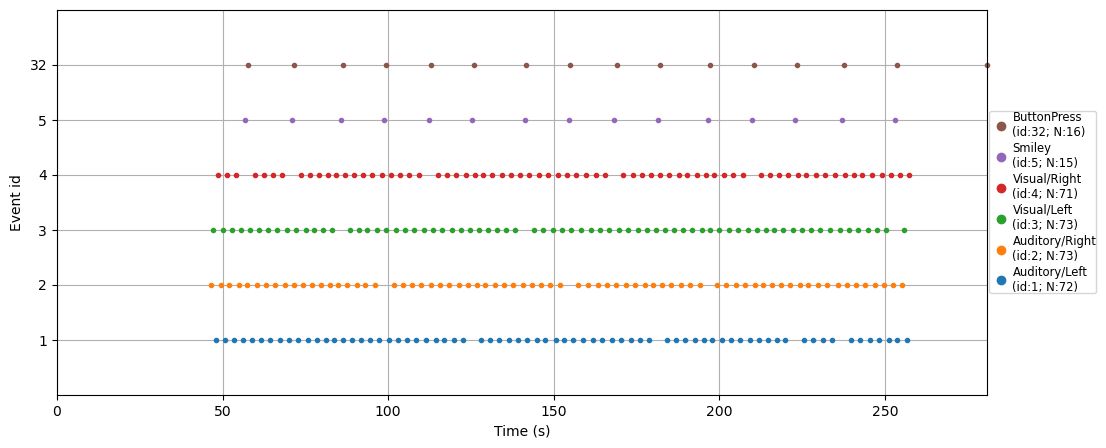

In [6]:
events = mne.find_events(reconst_raw, stim_channel="STI 014")
eventTypes, eventCounts = np.unique(events[:, 2], return_counts=True)

eventDict = {"Auditory/Left": 1, "Auditory/Right": 2,"Visual/Left": 3, "Visual/Right": 4, "Smiley": 5, "ButtonPress": 32} #includes all possible events from MNE documentation
print("\nThere are 6 types of events.", eventCounts[0], "Auditory/Left,", eventCounts[1], "Auditory/Right,", eventCounts[2], "Visual/Left,", eventCounts[3], "Visual/Right,", eventCounts[4], "Smiley, and", eventCounts[5], "ButtonPress events occured.\n")

fig, ax = plt.subplots(figsize=(15, 5)) #creates axes to be used to manipulate figure size of mne plot, since can't change it natively
plot = mne.viz.plot_events(events, sfreq=reconst_raw.info['sfreq'], event_id=eventDict, axes=ax) #plots the events w/ sampling freqency of the raw data (otherwise would get by sample instead of by time)

<strong><font size="4.5">1.3 (B)</font></strong>

1. The events appear to be fairly distributed in time. However, we do see that there are small breaks, meaning that there is not very much clustering in specific parts of the data (for example, heavily clustered in 50-100ms) but there is local clustering (for xample, for Auditory/Right we seee a cluster in the roughly 50-100ms range). Therefore, there is some clustering in time within the data.
2. Since the events all start at roughly the same time (just under 50 seconds) and end at around the same time (just over 250 seconds), as well as having nearly no breaks in the data, it seems that the events are predictable. There appear to be breaks in the audio and visual data, but this occurs seemlingly in line with "Smiley" for "Visual" data and "ButtonPress" for "Auditory" data. Smiley and ButtonPress data occurs at evenly spaced intervals, except for one outlier occuring right at the end of the data for ButtonPress. In general, the events are predictable, although the auditory and visual events are slightly more randomized in time.
3. Since the stimuli seem to be predictable and correlative, I would imagine that the time distribution could affect the brain response. The subjects of the experiments may begin to predict when certain stimuli will be introduced, which may interfere w/ the brain response.

<strong><font size="6">1.4</font></strong>

Not setting metadata
320 matching events found
Setting baseline interval to [-0.19979521315838786, 0.0] s
Applying baseline correction (mode: mean)
Created an SSP operator (subspace dimension = 3)
3 projection items activated
Using data from preloaded Raw for 320 events and 541 original time points ...
0 bad epochs dropped


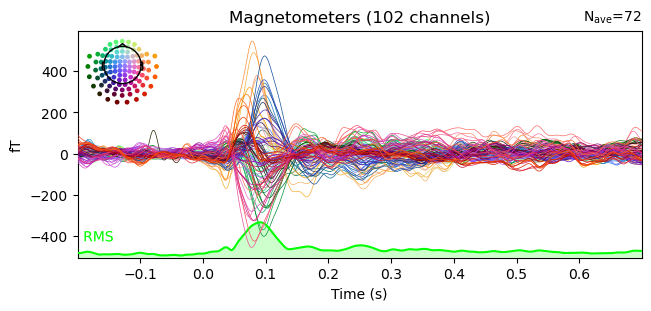

Projections have already been applied. Setting proj attribute to True.


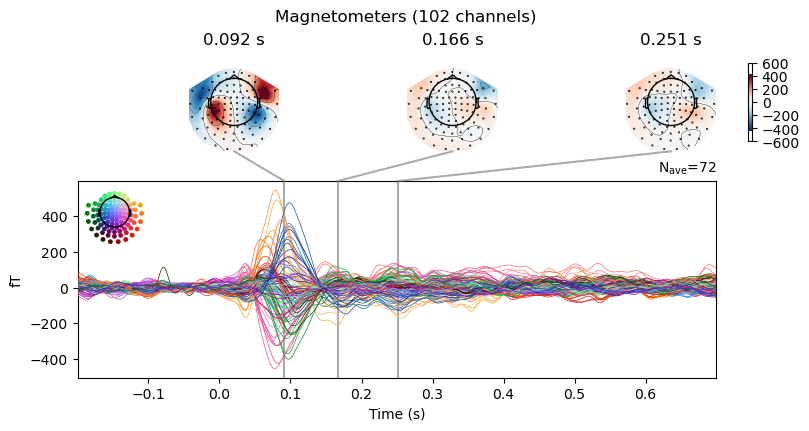

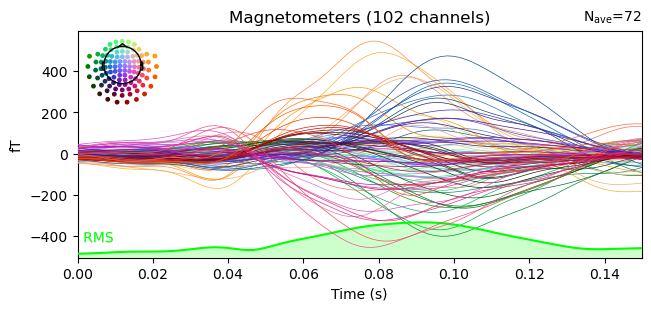

Projections have already been applied. Setting proj attribute to True.


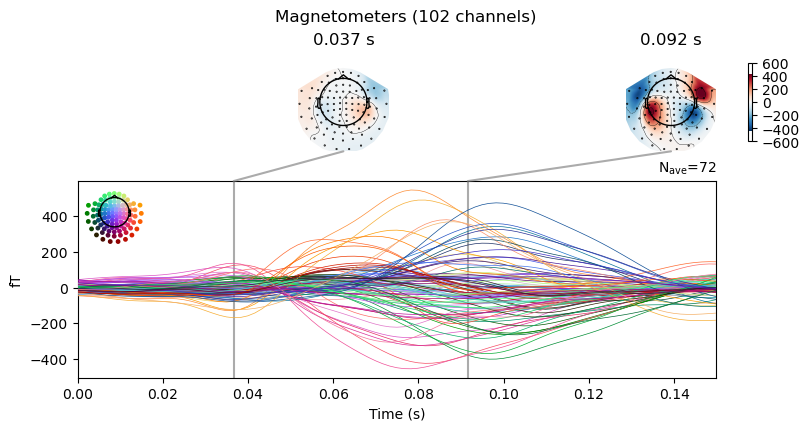

Channels marked as bad:
['MEG 2443', 'EEG 053']
Channels marked as bad:
['MEG 2443', 'EEG 053']


In [7]:
epochs = mne.Epochs(reconst_raw, events, event_id=eventDict, tmin=-0.2, tmax=0.7, picks='mag', preload=True) #takes only magnometer data, from 200ms before and 700ms after each event
evoked = epochs["Auditory/Left"].average() #takes just the left auditory data
cropped = evoked.copy().crop(tmin=0, tmax=0.15) # time cropped to focus on first 150ms of the event

evoked.plot(gfp=True)
plot = evoked.plot_joint() #call it plot to not output an image as well
cropped.plot(gfp=True)
plot = cropped.plot_joint()

<strong><font size="4.5">1.4 (A)</font></strong>

The automatic RMS peaks are useful. We can see that all of the reading have generally the same shape, albeit some are negative. The data trends in the same way, and we can see that the RMS captures the large spike at 90-95ms. However, if you zoom into the data, it picks up a spike that was not previously there at between 35-40ms. This means that the RMS are somewhat useful, but provide false positives.

<strong><font size="4.5">1.4 (B)</font></strong>

1. You could use the look for local maxima that go above a specific threshold. If you look back at the original plot, you can see that there is only one spike with drastically different magnitude than the rest. It is the only value that exceeds a magnitude of 200, meaning that we can check for spikes only with a magnitude above 200. This could be done in code, or since the data is small enough we can do it manually.
2. 

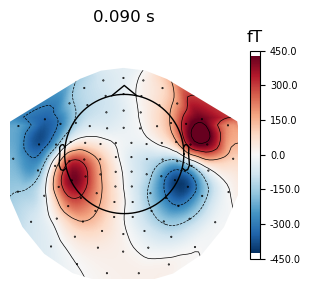

In [8]:
manualPeak = [0.09]
plot = cropped.plot_topomap(times=manualPeak, size=2)

3. Based on this, as well as looking at the topomap data of the "incorrect" detection points in the original graph w/ RMS, we can see that there is a very strong magnetic polarization on the side of the head, appearing to be most concentrating in the temporal lobe (which is responsible for auditory processing). We can see that before, there is little activity occuring, then when the auditory event occurs, extreme polarization (indicating neuron firing), then again we see that there is little activity once the brain has processed the sound.

<strong><font size="4.5">1.4 (C)</font></strong>

Projections have already been applied. Setting proj attribute to True.


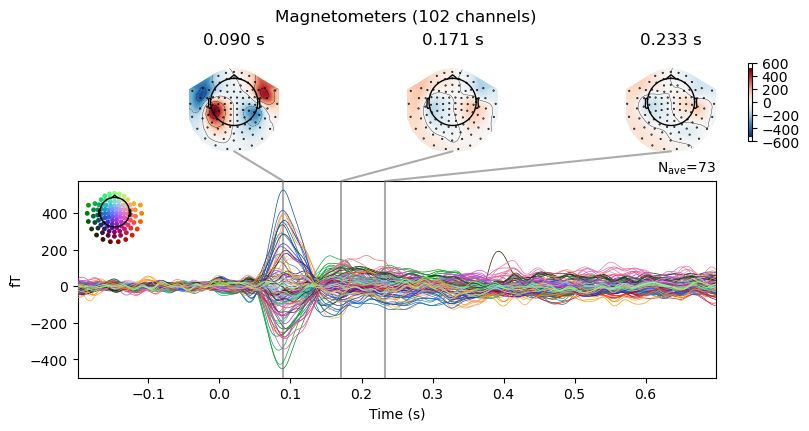

Projections have already been applied. Setting proj attribute to True.


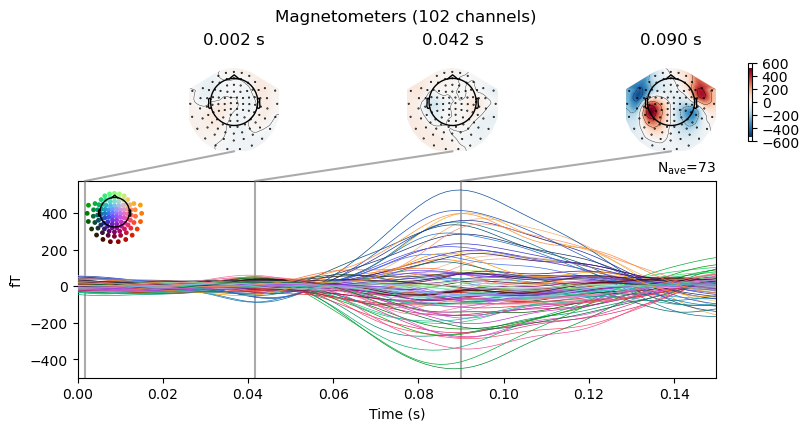

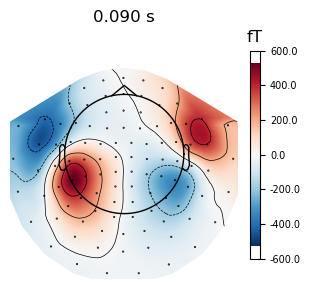

In [9]:
evoked = epochs["Auditory/Right"].average() #takes just the right auditory data
cropped = evoked.copy().crop(tmin=0, tmax=0.15) 
plot = evoked.plot_joint() #call it plot to not output an image as well
plot = cropped.plot_joint()

manualPeak = [0.09]
plot = cropped.plot_topomap(times=manualPeak, size=2)

As we can see, the behaviour is extremely similar to the left ear. We see a spike at roughly the same time, although all channels seems to come in much more closely together. I will assume this is due to the placement of the sensors on the head, and is not indicative of anything within the data. 

Interestingly, the polarization appears to be in the same spot in the brain. This goes against what I would have expected, as I would expect it to be flipped as each ear should be connected to the opposite lobe within the brain. So from this I can conclude that regardless of the type of 

<strong><font size="4.5">1.4 (D)</font></strong>

Projections have already been applied. Setting proj attribute to True.


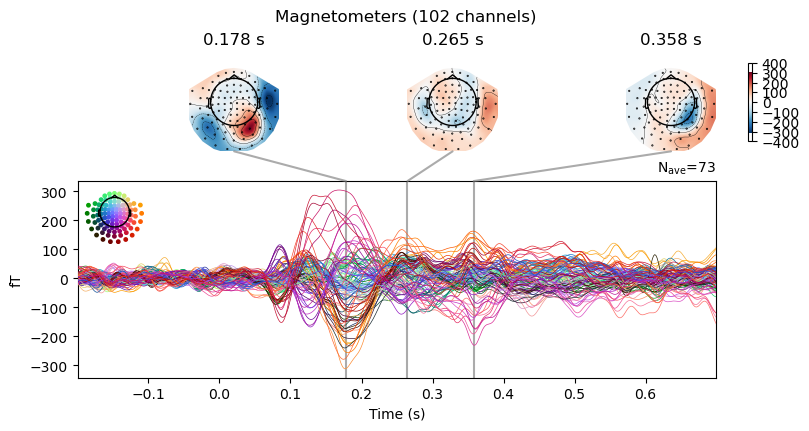

Projections have already been applied. Setting proj attribute to True.


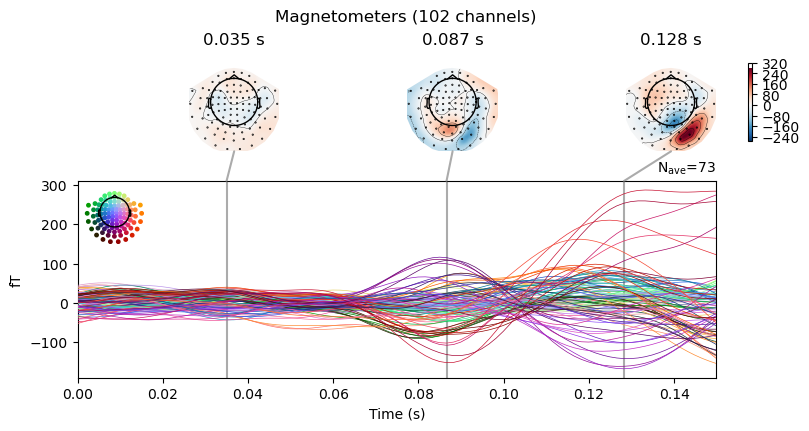

Projections have already been applied. Setting proj attribute to True.


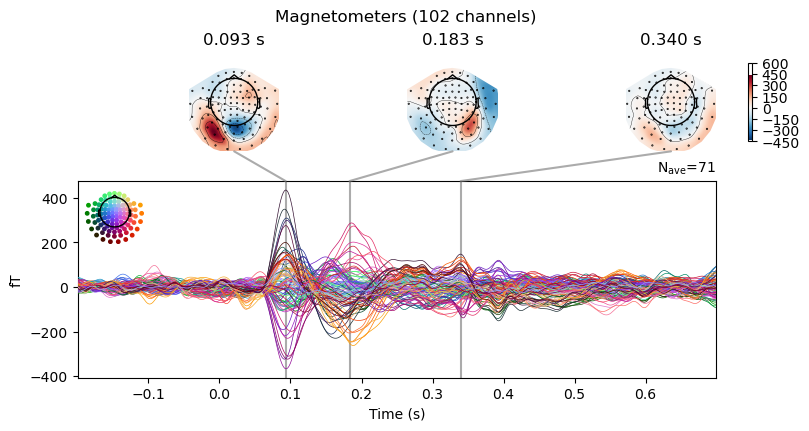

Projections have already been applied. Setting proj attribute to True.


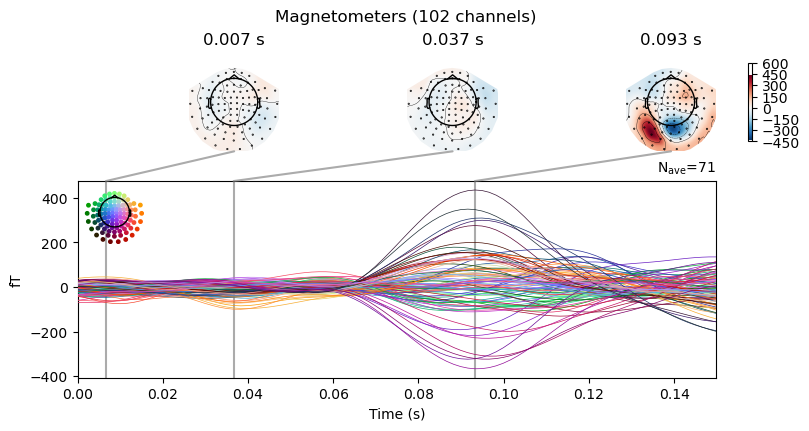

In [10]:
evokedLEye = epochs["Visual/Left"].average() #takes just the left visual data
croppedLE = evokedLEye.copy().crop(tmin=0, tmax=0.15)
evokedREye = epochs["Visual/Right"].average() #takes just the right visual data
croppedRE = evokedREye.copy().crop(tmin=0, tmax=0.15)

plotLEye = evokedLEye.plot_joint()
plotLEye = croppedLE.plot_joint()
plotREye = evokedREye.plot_joint()

plotREye = croppedRE.plot_joint()


The signals behave in very similar ways. Before cropping the left eye's signal to just within 150ms, it appears to behave differently from the right eye. However, this is again due to what I assume is noisier data coming from the left side due to the sensors. 

Both have a drastically more extreme event occuring around the 100ms mark (between 90ms and 130ms). This is very similar to the auditory response. They also seem to have high magnetic polarization in the area responsible for those senses. 
In this case, the visual cortex (occipital lobe) has strong polarization during the event. This behaviour is more what I expected during the auditory phase, as the left part of the occipital lobe lights up for the right eye, and vice versa. The other major difference is that it appears that the visual data is being processed for a much longer amount of time, since the data does not seem to settle towards 0 nearly as quickly as the auditory data.

<strong><font size="4.5">1.4 (E)</font></strong>

Not setting metadata
320 matching events found
Setting baseline interval to [-0.19979521315838786, 0.0] s
Applying baseline correction (mode: mean)
0 projection items activated
Using data from preloaded Raw for 320 events and 541 original time points ...
0 bad epochs dropped
No projector specified for this dataset. Please consider the method self.add_proj.


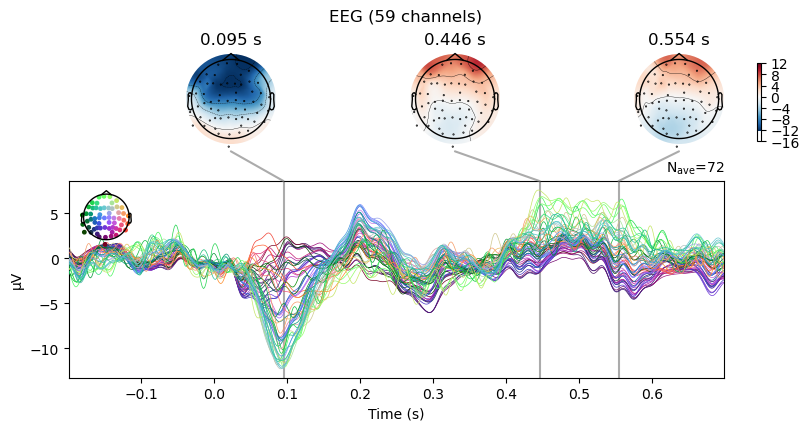

No projector specified for this dataset. Please consider the method self.add_proj.


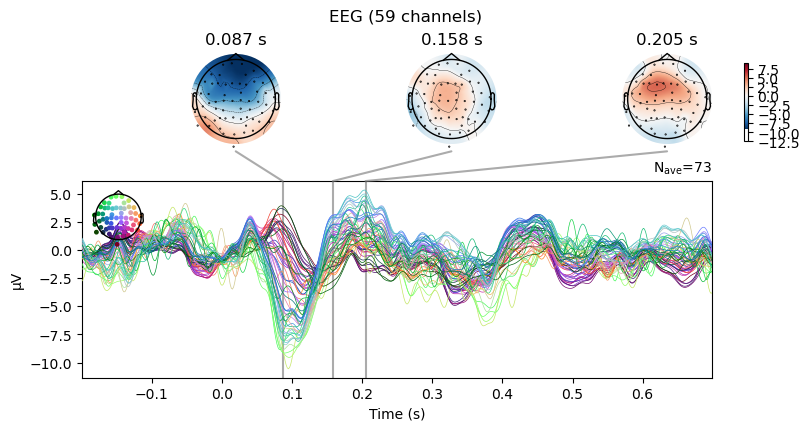

No projector specified for this dataset. Please consider the method self.add_proj.


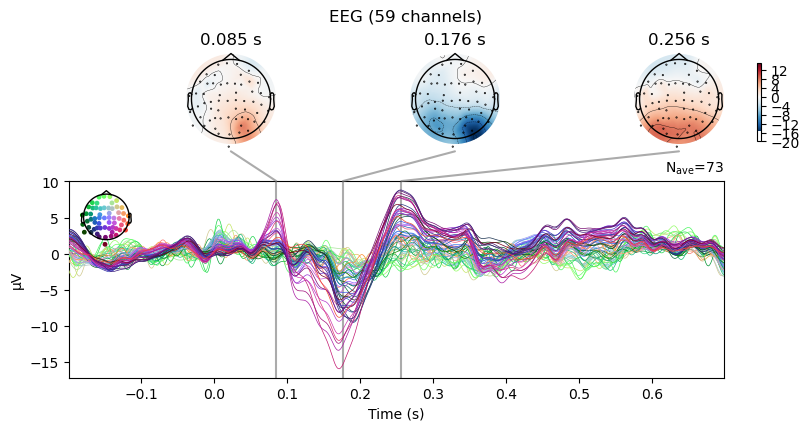

No projector specified for this dataset. Please consider the method self.add_proj.


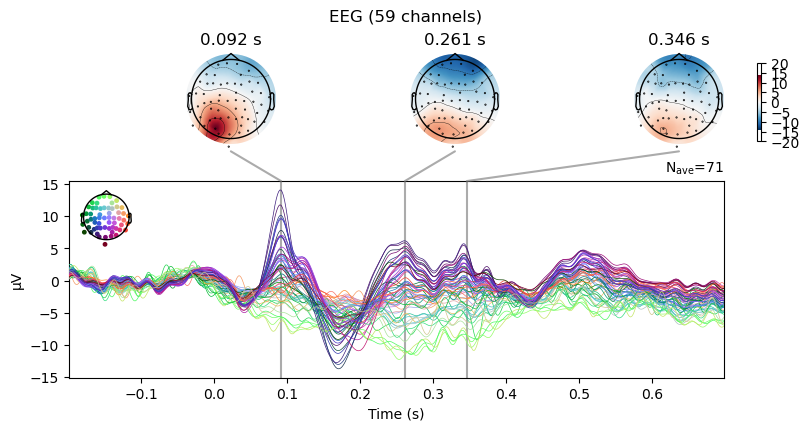

In [11]:
#takes only EEG data, from 200ms before and 700ms after each event
epochs = mne.Epochs(reconst_raw, events, event_id=eventDict, tmin=-0.2, tmax=0.7, picks='eeg', preload=True)

#Left Ear
evoked = epochs["Auditory/Left"].average()
leftEar = evoked.plot_joint()

# Right Ear
evoked = epochs["Auditory/Right"].average()
rightEar = evoked.plot_joint()

#left Eye
evoked = epochs["Visual/Left"].average()
leftEye = evoked.plot_joint()

#Right Eye
evoked = epochs["Visual/Right"].average()
rightEye = evoked.plot_joint()

The EEG data is substantially noisier than the MEG data, or at the very least shows that the brain is more active than the MEG data seems to suggest. It also seems to pick up both a large depolarization and then repolarization during the auditory event, or polarization and depolarization during the visual event. This is different from just the magnetic polarization that occured in the MEG data.

The events appear at the same time in both the EEG and MEG data, at near the 90ms mark. Interestingly, the depolarization for auditory processing occurs in the frontal lobe, which may indicate that there is processing of the sound occuring rather than just a response to auditory stimulus.  

The visual data appears to be quite similar, with the electric polarization occuring in the same spot as the magnetic polarization in the MEG data. 